<a href="https://colab.research.google.com/github/Natalina04/Ensino-Superior-no-Brasil/blob/main/2020_Machine_Learning_Previs%C3%A3o_de_nota_do_ENEM_MAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

FGV EPGE - Escola de Pós-Graduação em Economia
==
Machine Learning


Aluna:Maria Natalina Ferreira Costa

**Premissa:**
Esse trabalho parte da premissa que fatores socioeconômicos  tem uma relação direta com o desempenho dos alunos no Exame Nacional do Ensino Médio. Dessa forma, nos propomos a mostrar estatisticamente o que o senso comum já nos indica, que alunos sob determinadas condições precisam ser outliers do seu meio para sobressaírem à própria realidade.

**Estruturação:**
Inicialmente foram usados os dados do questionário socioeconômico preenchido pelos alunos no momento da inscrição para o ENEM e comparados com seu desempenho em cada área de conhecimento, verificando a correlação entre cada variável e a partir de então estabelecendo um modelo capaz de predizer o desempenho do aluno.

In [ ]:
#Importando Bibliotecas
import seaborn as sns
from google.colab import drive
import sklearn
#assert sklearn.__version__ >= "0.20"
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import urllib.request
import pandas as pd
import sklearn.linear_model
import os
from google.colab import drive

In [ ]:
#Abrindo arquivo com os dados publicos de educação
drive.mount('/content/Drive')
root_path = '/content/drive/My Drive/"Machine Learning - MFEE"/MICRODADOS_ENEM_2020.csv'
csv_enem = '/content/drive/My Drive/"Machine Learning - MFEE"/MICRODADOS_ENEM_2020.csv'

Drive already mounted at /content/Drive; to attempt to forcibly remount, call drive.mount("/content/Drive", force_remount=True).


**Tratamento inicial dos dados:**
Inicialmente foram analisadas as colunas da tabela, que tem sua descrição no Dicionário de atributos. Foram excluídas todas as colunas com dados de alunos com necessidades especiais, códigos de cidades e de estados, vetores com o gabarito de cada aluno, códigos de provas, entre outros que são irrelevantes para a análise proposta.
Posteriormente foi realizada a retirada dos dados dos alunos que faltaram a qualquer uma das provas ou que tiraram nota 0.



In [ ]:
csv_enem = pd.read_csv('/content/Drive/MyDrive/MICRODADOS_ENEM_2020.csv', nrows=30, encoding='iso-8859-1', sep=';')
csv_enem.head()

,NU_INSCRICAO,NU_ANO,TP_FAIXA_ETARIA,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,...,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
0,200006271946,2020,11,F,1,2,1,1,11,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,200001195856,2020,11,M,2,3,1,1,11,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,200001943954,2020,4,F,2,3,2,2,0,2,...,B,A,A,B,A,A,A,A,A,A
3,200001908998,2020,2,M,1,3,1,2,0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,200001634757,2020,4,F,1,3,2,1,1,1,...,A,A,A,B,A,B,B,A,A,B


In [ ]:
#Retirada de colunas com informações irrelevantes para a análise
cols = csv_enem.columns.values.tolist()
drop_cols = ('IN', 'NU_ANO', 'TX_', 'NO_', 'SG_')
for col in cols[:]:
    if col.startswith(drop_cols):
        cols.remove(col)

csv_enem = pd.read_csv('/content/Drive/MyDrive/MICRODADOS_ENEM_2020.csv', encoding='iso-8859-1', sep=';', usecols=cols)

print('Meu banco de dados agora tem', len(cols), 'colunas e', len(csv_enem.index), 'linhas.' )

Meu banco de dados agora tem 62 colunas e 5783109 linhas.


In [ ]:
# Retirada dos dados de alunos que faltaram a qualquer uma das provas
for col in ['TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'TP_PRESENCA_MT']:
    csv_enem = csv_enem[csv_enem[col] == 1]

print('Meu banco de dados agora tem', len(cols), 'colunas e', len(csv_enem.index), 'linhas.' )

Meu banco de dados agora tem 62 colunas e 2588681 linhas.


In [ ]:
# Eliminando os alunos que tiraram 0 em qualquer uma das provas
for col in ['NU_NOTA_MT', 'NU_NOTA_CH', 'NU_NOTA_CN', 'NU_NOTA_LC', 'NU_NOTA_REDACAO']:
    csv_enem = csv_enem[csv_enem[col] != 0]

print('Meu banco de dados agora tem', len(cols), 'colunas e', len(csv_enem.index), 'linhas.' )

Meu banco de dados agora tem 62 colunas e 2527394 linhas.


In [ ]:
# Eliminando os alunos que não estão concluindo o 3º ano em 2019
#for col in ['TP_ST_CONCLUSAO']:
    #csv_enem = csv_enem[csv_enem[col] == 2]

#print('Meu banco de dados agora tem', len(cols), 'colunas e', len(csv_enem.index), 'linhas.' )

**1 - Análise dos atributos com relação à nota de Matemática**
--

A partir de agora vamos analisar a distribuição dos resultados na prova de matemática e a relação desta com os atributos.

In [ ]:
# Análise da distribuição dos resultados de matemática
notamt = 'NU_NOTA_MT'
csv_enem[notamt].describe()

count    2.527394e+06
mean     5.226298e+02
std      1.170359e+02
min      3.271000e+02
25%      4.276000e+02
50%      5.078000e+02
75%      6.043000e+02
max      9.750000e+02
Name: NU_NOTA_MT, dtype: float64

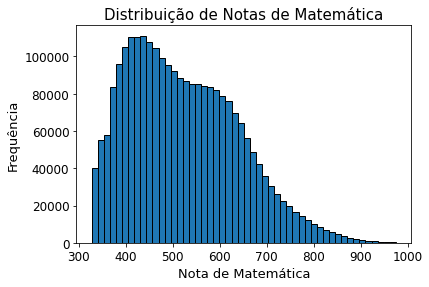

In [ ]:
plt.title('Distribuição de Notas de Matemática', fontsize=15)
plt.xlabel('Nota de Matemática', fontsize=13)
plt.ylabel('Frequência', fontsize=13)
plt.tick_params(labelsize=12)
plt.hist(csv_enem[notamt], 50, rwidth=3, edgecolor='black')
plt.show()

**1.1 - Escolaridade do pai vs Nota Matemática**

Conforme gráfico abaixo, pode-se observar que a escolaridade do pai tem grande influência para a nota de matemática, de modo que, quanto maior a escolaridade, maior a nota esperada.

Nota-se ainda uma grande quantidade de respostas "Não sei", que poderão gerar problemas na montagem do modelo, uma vez que podem ser encarados como Missing Values.

Text(0, 0.5, 'Nota de Matemática')

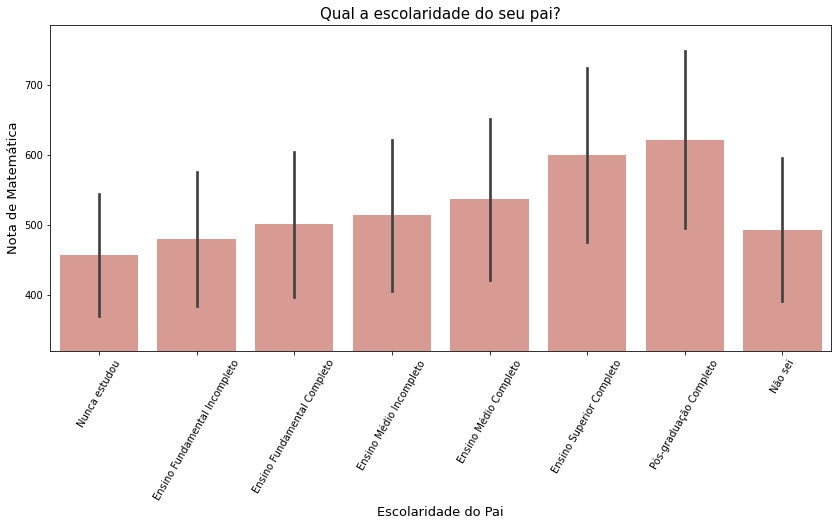

In [ ]:
# Análise da relação Nota de Matemática x Escolaridade do Pai
var1 = 'Q001'
A = 'Nunca estudou'
B = 'Ensino Fundamental Incompleto'
C = 'Ensino Fundamental Completo'
D = 'Ensino Médio Incompleto'
E = 'Ensino Médio Completo'
F = 'Ensino Superior Completo'
G = 'Pós-graduação Completo'
H = 'Não sei'
plotdata = pd.concat([csv_enem[notamt], csv_enem[var1].map({'A': A, 'B': B, 'C': C, 'D': D, 'E': E, 'F': F, 'G': G, 'H': H})], axis=1)
f, ax = plt.subplots(figsize=(14, 6))
fig = sns.barplot(x=var1, y=csv_enem[notamt], data=plotdata, order=[A, B, C, D, E, F, G, H], ci='sd', color='salmon', saturation=.5)
fig.axis(ymin=320);
ax.set_xticklabels(ax.get_xticklabels(),rotation=60)
fig.set_title("Qual a escolaridade do seu pai?", fontsize=15)
fig.set_xlabel("Escolaridade do Pai", fontsize=13)
fig.set_ylabel("Nota de Matemática", fontsize=13)

**1.2 - Escolaridade da mãe vs Nota Matemática**

Conforme gráfico abaixo, pode-se observar que a escolaridade da mãe tem grande influência para a nota de matemática, de modo que, quanto maior a escolaridade, maior a nota esperada.

Nota-se ainda uma grande quantidade de respostas "Não sei", que poderão gerar problemas na montagem do modelo, uma vez que podem ser encarados como Missing Values.

Text(0, 0.5, 'Nota de Matemática')

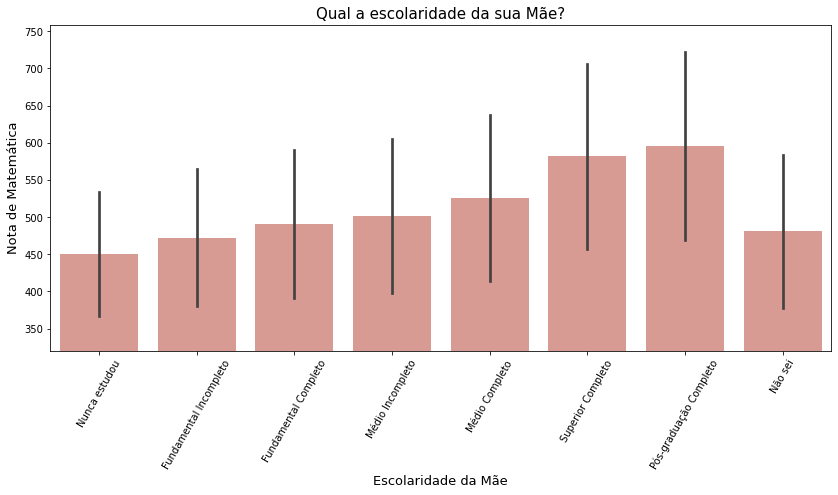

In [ ]:
# Análise da relação Nota de Matemática x Escolaridade da Mãe
var2 = 'Q002'
A = 'Nunca estudou'
B = 'Fundamental Incompleto'
C = 'Fundamental Completo'
D = 'Médio Incompleto'
E = 'Médio Completo'
F = 'Superior Completo'
G = 'Pós-graduação Completo'
H = 'Não sei'
plotdata = pd.concat([csv_enem[notamt], csv_enem[var2].map({'A': A, 'B': B, 'C': C, 'D': D, 'E': E, 'F': F, 'G': G, 'H': H})], axis=1)
f, ax = plt.subplots(figsize=(14, 6))
fig = sns.barplot(x=var2, y=csv_enem[notamt], data=plotdata, order=[A, B, C, D, E, F, G, H], ci='sd', color='salmon', saturation=.5)
fig.axis(ymin=320);
ax.set_xticklabels(ax.get_xticklabels(),rotation=60)
fig.set_title("Qual a escolaridade da sua Mãe?", fontsize=15)
fig.set_xlabel("Escolaridade da Mãe", fontsize=13)
fig.set_ylabel("Nota de Matemática", fontsize=13)

**1.3 - Ocupação do pai vs Nota Matemática**

Conforme gráfico abaixo, pode-se observar que a ocupação do pai tem grande influência para a nota de matemática, de modo que, quanto maior a escolaridade, maior a nota esperada.

Nota-se ainda uma grande quantidade de respostas "Não sei", que poderão gerar problemas na montagem do modelo, uma vez que podem ser encarados como Missing Values.

Text(0, 0.5, 'Nota de Matemática')

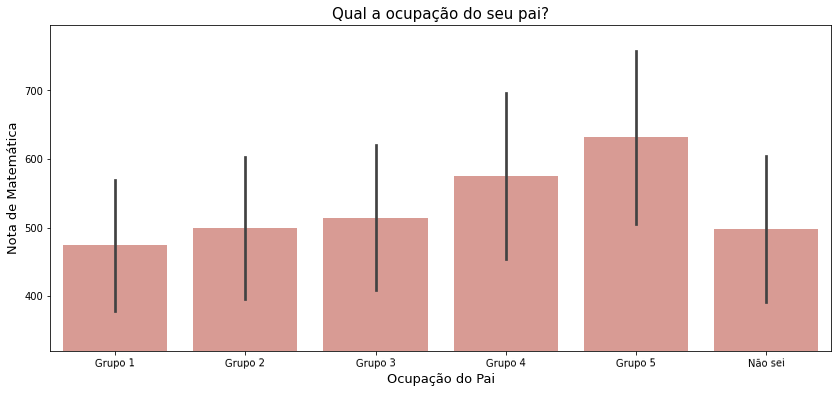

In [ ]:
# Análise da relação Nota de Matemática x Ocupação do Pai
var3 = 'Q003'
A = 'Grupo 1'#Lavrador, agricultor sem empregados'
B = 'Grupo 2' # Diarista, empregado doméstico'
C = 'Grupo 3' #Padeiro, cozinheiro industrial'
D = 'Grupo 4' #Professor, técnico, policial, militar'
E = 'Grupo 5' #Médico, engenheiro, dentista'
F = 'Não sei'
plotdata = pd.concat([csv_enem[notamt], csv_enem[var3].map({'A': A, 'B': B, 'C': C, 'D': D, 'E': E, 'F': F,})], axis=1)
f, ax = plt.subplots(figsize=(14, 6))
fig = sns.barplot(x=var3, y=csv_enem[notamt], data=plotdata, order=[A, B, C, D, E, F], ci='sd', color='salmon', saturation=.5)
fig.axis(ymin=320);
ax.set_xticklabels(ax.get_xticklabels(),rotation=1)
fig.set_title("Qual a ocupação do seu pai?", fontsize=15)
fig.set_xlabel("Ocupação do Pai", fontsize=13)
fig.set_ylabel("Nota de Matemática", fontsize=13)

**1.4 - Ocupação da mãe vs Nota Matemática**

Conforme gráfico abaixo, pode-se observar que a ocupação da mãe tem grande influência para a nota de matemática, de modo que, quanto maior a escolaridade, maior a nota esperada.

Nota-se ainda uma grande quantidade de respostas "Não sei", que poderão gerar problemas na montagem do modelo, uma vez que podem ser encarados como Missing Values.

Text(0, 0.5, 'Nota de Matemática')

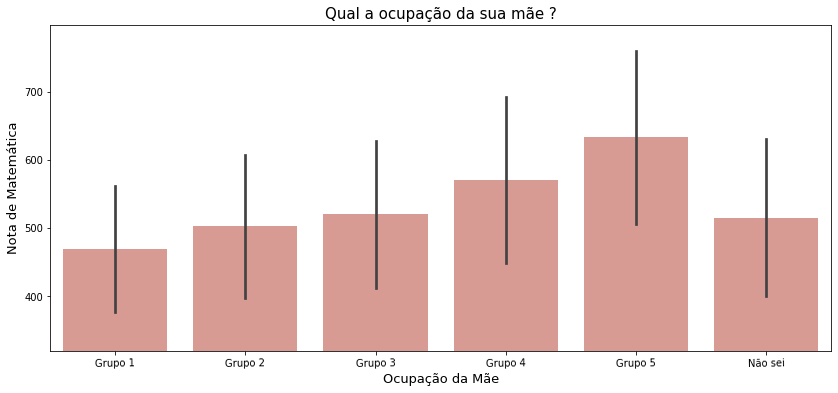

In [ ]:
# Análise da relação Nota de Matemática x Ocupação da Mãe
var4 = 'Q004'
A = 'Grupo 1'#Lavradora, agricultora sem empregados'
B = 'Grupo 2' # Diarista, empregada doméstica'
C = 'Grupo 3' #Padeira, cozinheira industrial'
D = 'Grupo 4' #Professora, técnica, policial, militar'
E = 'Grupo 5' #Médica, engenheira, dentista'
F = 'Não sei'
plotdata = pd.concat([csv_enem[notamt], csv_enem[var4].map({'A': A, 'B': B, 'C': C, 'D': D, 'E': E, 'F': F,})], axis=1)
f, ax = plt.subplots(figsize=(14, 6))
fig = sns.barplot(x=var4, y=csv_enem[notamt], data=plotdata, order=[A, B, C, D, E, F], ci='sd', color='salmon', saturation=.5)
fig.axis(ymin=320);
ax.set_xticklabels(ax.get_xticklabels(),rotation=1)
fig.set_title("Qual a ocupação da sua mãe ?", fontsize=15)
fig.set_xlabel("Ocupação da Mãe", fontsize=13)
fig.set_ylabel("Nota de Matemática", fontsize=13)

**1.5 - Número de coabitantes vs Nota Matemática**

Do gráfico abaixo podemos observar que o número de coabitantes não é um fator que influencia a nota de modo direto.

Text(0, 0.5, 'Nota de Matemática')

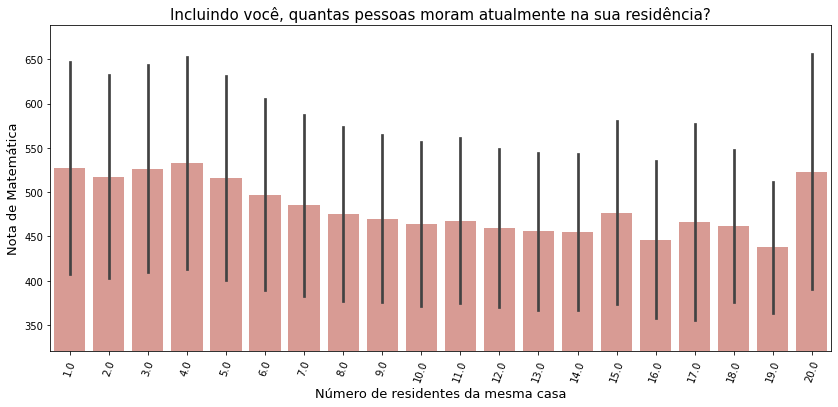

In [ ]:
# Análise da relação Nota de Matemática x Número de residentes na mesma casa
var5 = 'Q005'
plotdata = pd.concat([csv_enem[notamt], csv_enem[var5]], axis=1)
f, ax = plt.subplots(figsize=(14, 6))
fig = sns.barplot(x=var5, y=csv_enem[notamt], data=plotdata, ci='sd', color='salmon', saturation=.5)
fig.axis(ymin=320);
ax.set_xticklabels(ax.get_xticklabels(),rotation=70)
fig.set_title("Incluindo você, quantas pessoas moram atualmente na sua residência?", fontsize=15)
fig.set_xlabel("Número de residentes da mesma casa", fontsize=13)
fig.set_ylabel("Nota de Matemática", fontsize=13)

**1.6 - Renda Familiar vs Nota Matemática**

Do Gráfico abaixo podemos tirar a conclusão que a renda familiar tem relação direta com a nota de matemática. Conforme observamos, alunos que não tem qualquer renda tem média muito inferior a alunos com renda superior a R$ 19.960,00.

Uma dúvida que surgiu fica por conta de indicadores financeiros de qualidade de vida de um país, que são medidas por renda per capita. De forma análoga podemos dizer o mesmo em relação a este quesito? Afinal, família de classe média mas com muitos integrantes sofrem queda brusca na qualidade de vida em termos financeiros e perdem acesso a melhores oportunidades de educação em virtude da baixa renda disponível para habitante da casa. Dessa forma, nosso próximo passo será verificar se a relação da entre renda per capita e nota de matemática se mantém, conforme observado nessa relação da nota com a renda familiar.


Text(0, 0.5, 'Nota de Matemática')

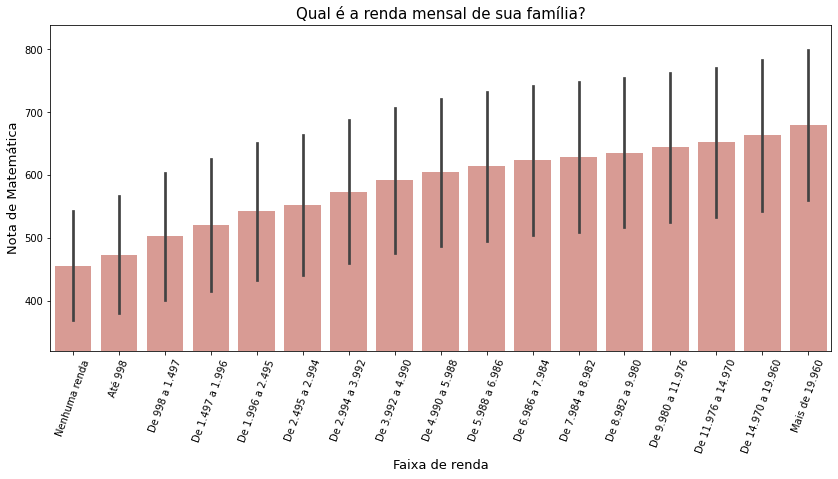

In [ ]:
# Análise da relação Nota de Matemática x Renda familiar
var6 = 'Q006'
A = 'Nenhuma renda'
B = 'Até 998'
C = 'De 998 a 1.497'
D = 'De 1.497 a 1.996'
E = 'De 1.996 a 2.495'
F = 'De 2.495 a 2.994'
G = 'De 2.994 a 3.992'
H = 'De 3.992 a 4.990'
I = 'De 4.990 a 5.988'
J = 'De 5.988 a 6.986'
K = 'De 6.986 a 7.984'
L = 'De 7.984 a 8.982'
M = 'De 8.982 a 9.980'
N = 'De 9.980 a 11.976'
O = 'De 11.976 a 14.970'
P = 'De 14.970 a 19.960'
Q = 'Mais de 19.960'
plotdata = pd.concat([csv_enem[notamt], csv_enem[var6].map({'A': A, 'B': B, 'C': C, 'D': D, 'E': E, 'F': F, 'G': G, 'H': H, 'I': I, 'J': J, 'K': K, 'L': L, 'M': M, 'N': N, 'O': O, 'P': P, 'Q': Q})], axis=1)
f, ax = plt.subplots(figsize=(14, 6))
fig = sns.barplot(x=var6, y=csv_enem[notamt], data=plotdata, order=[A, B, C, D, E, F, G, H, I, J, K, L, M, N, O, P, Q], ci='sd', color='salmon', saturation=.5)
fig.axis(ymin=320);
ax.set_xticklabels(ax.get_xticklabels(),rotation=70)
fig.set_title("Qual é a renda mensal de sua família?", fontsize=15)
fig.set_xlabel("Faixa de renda", fontsize=13)
fig.set_ylabel("Nota de Matemática", fontsize=13)

**1.7 - Frequência de empregado(a) doméstico(a) vs Nota Matemática**

Do gráfico abaixo podemos perceber que há uma relação direta entre a nota e a frequência com que o aluno dispõe do serviço de empregado doméstico. Apesar de ser uma feature diretamente relacionada ao aspecto econômico, há uma singularidade nessa questão no que tange à disponibilidade do aluno para estudo, uma vez que quando há alguém contratado para realizar tarefas domésticas, os alunos não atuarão nessas funções ou caso o façam, o farão com intensidade inferior a quem não dispõe desse serviço.

A proposição acima faz sentido analisando os dados do gráfico. Não há uma diferença muito significativa entre quem dispõe de empregados com alguma frequência, ainda que baixa, ao passo que há uma grande diferença entre alunos que dispõe do serviço em frequência baixa em relação aos que não dispõe de forma alguma.

Text(0, 0.5, 'Nota de Matemática')

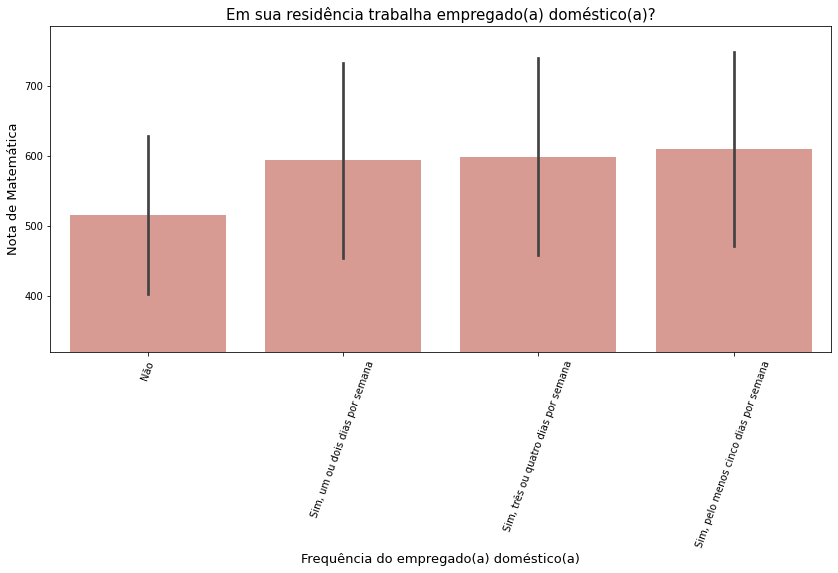

In [ ]:
# Análise da relação Nota de Matemática x Empregada doméstica
var7 = 'Q007'
A = 'Não'
B = 'Sim, um ou dois dias por semana'
C = 'Sim, três ou quatro dias por semana'
D = 'Sim, pelo menos cinco dias por semana'
plotdata = pd.concat([csv_enem[notamt], csv_enem[var7].map({'A': A, 'B': B, 'C': C, 'D': D})], axis=1)
f, ax = plt.subplots(figsize=(14, 6))
fig = sns.barplot(x=var7, y=csv_enem[notamt], data=plotdata, order=[A, B, C, D], ci='sd', color='salmon', saturation=.5)
fig.axis(ymin=320);
ax.set_xticklabels(ax.get_xticklabels(),rotation=70)
fig.set_title("Em sua residência trabalha empregado(a) doméstico(a)?", fontsize=15)
fig.set_xlabel("Frequência do empregado(a) doméstico(a)", fontsize=13)
fig.set_ylabel("Nota de Matemática", fontsize=13)

**1.8 - Quantidade de carros vs Nota Matemática**

Do gráfico abaixo podemos perceber que há uma relação direta entre a nota e a quantidade de carros que o aluno dispõe em sua residência. 

Essa feature pode ser importante considerando que alunos sem carro tendem a ter maiores dificuldades de deslocamento e podem ter sua frequência nas aulas reduzida.

Text(0, 0.5, 'Nota de Matemática')

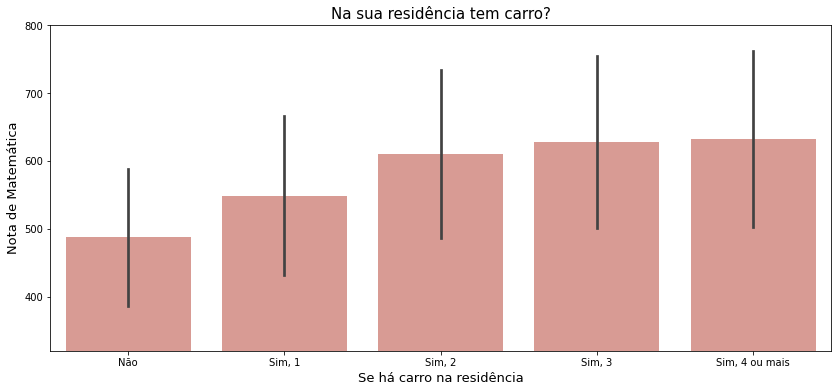

In [ ]:
# Análise da relação Nota de Matemática x Quantidade de carros
var8 = 'Q010'
A = 'Não'
B = 'Sim, 1'
C = 'Sim, 2'
D = 'Sim, 3'
E = 'Sim, 4 ou mais'
plotdata = pd.concat([csv_enem[notamt], csv_enem[var8].map({'A': A, 'B': B, 'C': C, 'D': D, 'E': E})], axis=1)
f, ax = plt.subplots(figsize=(14, 6))
fig = sns.barplot(x=var8, y=csv_enem[notamt], data=plotdata, order=[A, B, C, D, E], ci='sd', color='salmon', saturation=.5)
fig.axis(ymin=320);
ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
fig.set_title("Na sua residência tem carro?", fontsize=15)
fig.set_xlabel("Se há carro na residência", fontsize=13)
fig.set_ylabel("Nota de Matemática", fontsize=13)

**1.9 - Computador em casa vs Nota Matemática**

Do gráfico abaixo podemos perceber que há uma relação direta entre a nota e a quantidade de computadores que o aluno dispõe em sua residência. 

Essa feature foi considerada em detrimento da feature de acesso à internet, uma vez que o IBGE diz que 81% das pessoas acima de 10 anos tem acesso internet. Esse dado foi confirmado nesse questionário, conforme cálculo abaixo.

In [ ]:
internetaccess = csv_enem['Q025'].value_counts() 
print(internetaccess)
print('Somente', round(394472/(2106432+394472)*100, 2), '% dos alunos declararam não ter acesso à internet em casa.')

B    2106432
A     394472
Name: Q025, dtype: int64
Somente 15.77 % dos alunos declararam não ter acesso à internet em casa.


Text(0, 0.5, 'Nota de Matemática')

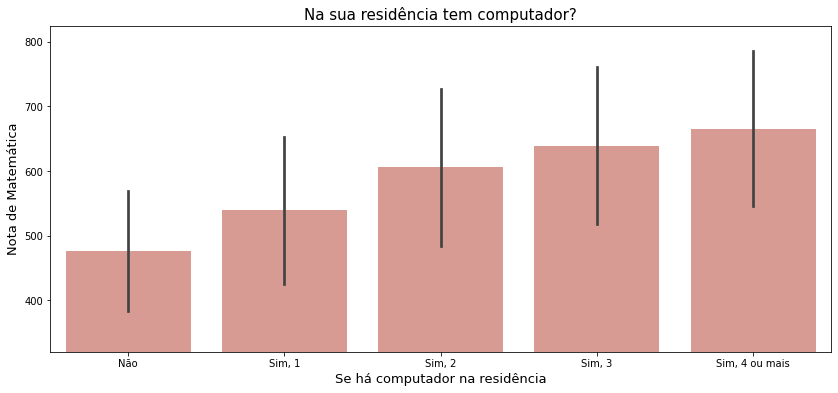

In [ ]:
# Análise da relação Nota de Matemática x Computador em casa
var9 = 'Q024'
A = 'Não'
B = 'Sim, 1'
C = 'Sim, 2'
D = 'Sim, 3'
E = 'Sim, 4 ou mais'
plotdata = pd.concat([csv_enem[notamt], csv_enem[var9].map({'A': A, 'B': B, 'C': C, 'D': D, 'E': E})], axis=1)
f, ax = plt.subplots(figsize=(14, 6))
fig = sns.barplot(x=var9, y=csv_enem[notamt], data=plotdata, order=[A, B, C, D, E], ci='sd', color='salmon', saturation=.5)
fig.axis(ymin=320);
ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
fig.set_title("Na sua residência tem computador?", fontsize=15)
fig.set_xlabel("Se há computador na residência", fontsize=13)
fig.set_ylabel("Nota de Matemática", fontsize=13)

**1.10 - Sexo vs Nota Matemática**

Do gráfico abaixo podemos perceber que há diferença de notas entre mulheres e homens na prova de matemática. Uma análise interessante a ser feita é se esse padrão de diferença de notas se confirma em outras matérias, o que poderia jogar uma luz quanto a uma questão amplamente discutida sobre o incentivo às mulheres para lidar com matérias relacionadas às áreas de exatas.

Text(0, 0.5, 'Nota de Matemática')

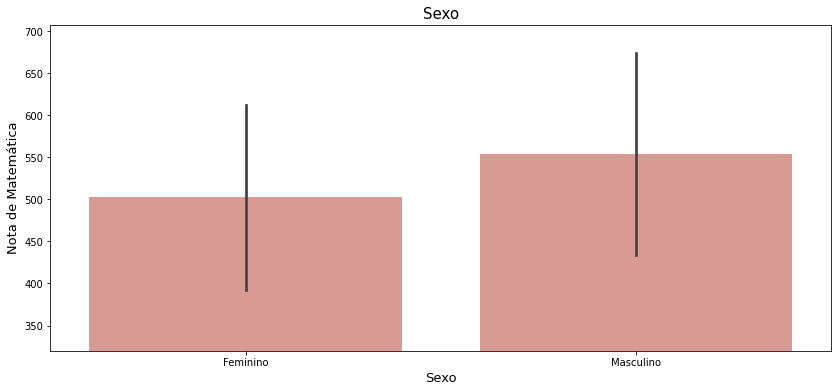

In [ ]:
# Análise da relação Nota de Matemática x Sexo do candidato
var10 = 'TP_SEXO'
M = 'Masculino'
F = 'Feminino'
plotdata = pd.concat([csv_enem[notamt], csv_enem[var10].map({'M': M, 'F': F})], axis=1)
f, ax = plt.subplots(figsize=(14, 6))
fig = sns.barplot(x=var10, y=csv_enem[notamt], data=plotdata, order=[F, M], ci='sd', color='salmon', saturation=.5)
fig.axis(ymin=320);
ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
fig.set_title("Sexo", fontsize=15)
fig.set_xlabel("Sexo", fontsize=13)
fig.set_ylabel("Nota de Matemática", fontsize=13)

**1.11 - Raça vs Nota Matemática**

Do gráfico abaixo podemos perceber que há diferença de notas entre raças, sendo as preta e indígena as que apresentaram as menores notas.

Essa feature apresenta problema de Missing values, uma vez que deu opção ao aluno optar pela opção 'Não declarado'. Missing Values serão tratados mais a frente e caso impossibilitem o uso dessa feature, essa deverá ser descartada.

A apresentação das ordens de média de nota por raça foram reordenadas para ficar visualmente clara a diferença de notas por raça. 

Text(0, 0.5, 'Nota de Matemática')

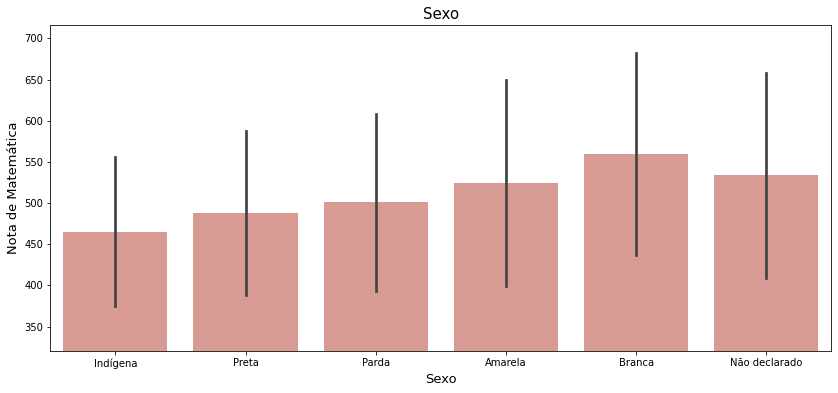

In [ ]:
# Análise da relação Nota de Matemática x Sexo do candidato
var11 = 'TP_COR_RACA'
A = 'Não declarado'
B = 'Branca'
C = 'Preta'
D = 'Parda'
E = 'Amarela'
F = 'Indígena'
plotdata = pd.concat([csv_enem[notamt], csv_enem[var11].map({0: A, 1: B, 2: C, 3: D, 4: E, 5: F})], axis=1)
f, ax = plt.subplots(figsize=(14, 6))
fig = sns.barplot(x=var11, y=csv_enem[notamt], data=plotdata, order=[F, C, D, E, B, A], ci='sd', color='salmon', saturation=.5)
fig.axis(ymin=320);
ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
fig.set_title("Sexo", fontsize=15)
fig.set_xlabel("Sexo", fontsize=13)
fig.set_ylabel("Nota de Matemática", fontsize=13)

**1.12 - Tipo de escola vs Nota Matemática**

Nessa feature estamos tentando verificar se o aluno é oriundo de Escola pública ou particular. Como há a opção ao aluno de não responder, verificamos que há uma outra questão em relação à dependência administrativa da escola, de modo que no tratamento das missing values podemos usar uma pergunta para responder outra, uma vez que consideramos ser informação crítica se o aluno é oriundo da rede pública ou privada.

Text(0, 0.5, 'Nota de Matemática')

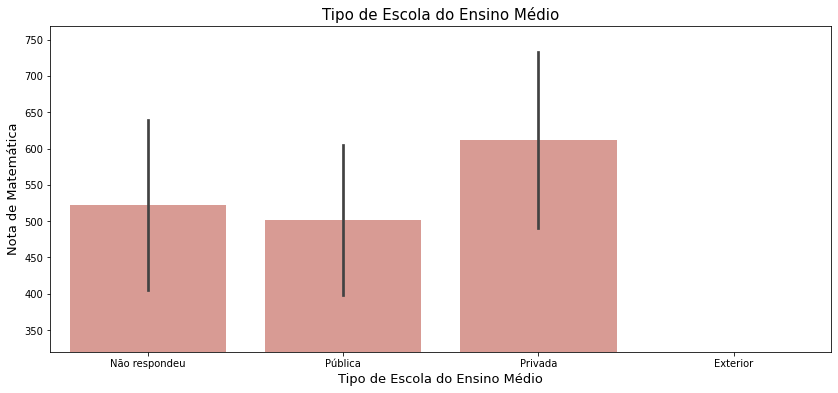

In [ ]:
# Análise da relação Nota de Matemática x Tipo de Escola do Ensino Médio
var12_1 = 'TP_ESCOLA'
A = 'Não respondeu'
B = 'Pública'
C = 'Privada'
D = 'Exterior'

plotdata = pd.concat([csv_enem[notamt], csv_enem[var12_1].map({1: A, 2: B, 3: C, 4: D})], axis=1)
f, ax = plt.subplots(figsize=(14, 6))
fig = sns.barplot(x=var12_1, y=csv_enem[notamt], data=plotdata, order=[A, B, C, D], ci='sd', color='salmon', saturation=.5)
fig.axis(ymin=320);
ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
fig.set_title("Tipo de Escola do Ensino Médio", fontsize=15)
fig.set_xlabel("Tipo de Escola do Ensino Médio", fontsize=13)
fig.set_ylabel("Nota de Matemática", fontsize=13)

In [ ]:
kindschool = csv_enem['TP_ESCOLA'].value_counts() 
print(kindschool)
csv_enem['TP_ESCOLA'].isnull().values.sum()
print('Nós temos', kindschool[1], 'missing values no atributo que define o tipo de escola de conclusão do ensino médio.')

1    1733888
2     631189
3     162317
Name: TP_ESCOLA, dtype: int64
Nós temos 1733888 missing values no atributo que define o tipo de escola de conclusão do ensino médio.


Text(0, 0.5, 'Nota de Matemática')

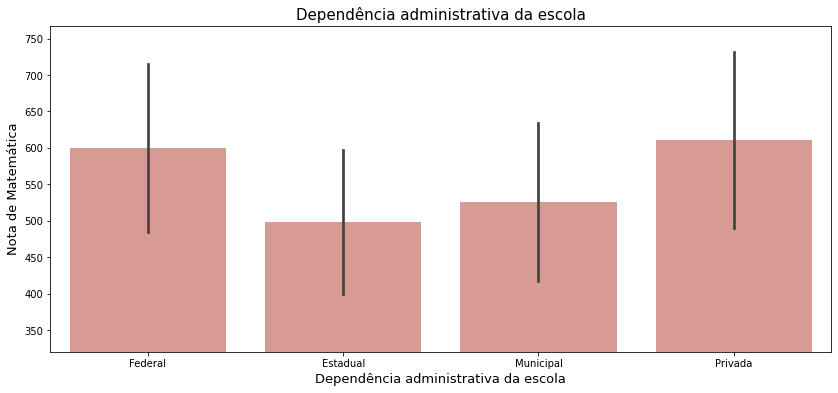

In [ ]:
# Análise da relação Nota de Matemática x Dependência administrativa da escola
var12_2 = 'TP_DEPENDENCIA_ADM_ESC'
A = 'Federal'
B = 'Estadual'
C = 'Municipal'
D = 'Privada'

plotdata = pd.concat([csv_enem[notamt], csv_enem[var12_2].map({1: A, 2: B, 3: C, 4: D})], axis=1)
f, ax = plt.subplots(figsize=(14, 6))
fig = sns.barplot(x=var12_2, y=csv_enem[notamt], data=plotdata, order=[A, B, C, D], ci='sd', color='salmon', saturation=.5)
fig.axis(ymin=320);
ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
fig.set_title("Dependência administrativa da escola", fontsize=15)
fig.set_xlabel("Dependência administrativa da escola", fontsize=13)
fig.set_ylabel("Nota de Matemática", fontsize=13)

In [ ]:
kindschool_2 = csv_enem['TP_DEPENDENCIA_ADM_ESC'].value_counts() 
print(kindschool_2)
print('Nós temos', csv_enem['TP_DEPENDENCIA_ADM_ESC'].isnull().values.sum(), 'missing values no atributo que define a dependência administrativa da escola.')

2.0    308368
4.0    175431
1.0     37579
3.0      4043
Name: TP_DEPENDENCIA_ADM_ESC, dtype: int64
Nós temos 2001973 missing values no atributo que define a dependência administrativa da escola.


**1.13 - Localização da Escola vs Nota Matemática**

Aqui tentaremos verificar se a localização da escola influencia na nota. Essa informação é importante pois, constitucionalmente, a responsabilidade da educação de Ensino Médio é do Estado. Caso sejam encontradas diferenças significativas de resultado entre Estados, encontramos diferenças de gestão do Executivo Estadual.

Na análise foi verificado que a seção "Dados da Escola" do questionário não foi preenchida por uma parte considerável dos alunos, nesse sentido, vamos usar os dados do Estado de residência do estudante, uma vez que todos alunos responderam a essa pergunta.

Caso na análise de Missing Values os dados não preenchidos sejam excluídos, valerá a pena se considerar a variável da escola de formação do Ensino Médio e não o de residência do estudante.


In [ ]:
localizationschool = csv_enem['CO_UF_ESC'].value_counts() 
print(localizationschool)
print('Nós temos', csv_enem['CO_UF_ESC'].isnull().values.sum(), 'missing values no atributo que define a localização da escola.')

35.0    97083
23.0    49546
31.0    46320
33.0    39820
29.0    31112
26.0    26787
41.0    26510
43.0    22745
15.0    20482
52.0    19549
21.0    15551
42.0    15387
53.0    14104
25.0    13348
32.0    11850
22.0    10598
24.0    10362
13.0    10318
27.0     8561
51.0     8480
50.0     6798
28.0     6469
11.0     4087
17.0     3926
12.0     2321
16.0     2064
14.0     1243
Name: CO_UF_ESC, dtype: int64
Nós temos 2001973 missing values no atributo que define a localização da escola.


Text(0, 0.5, 'Nota de Matemática')

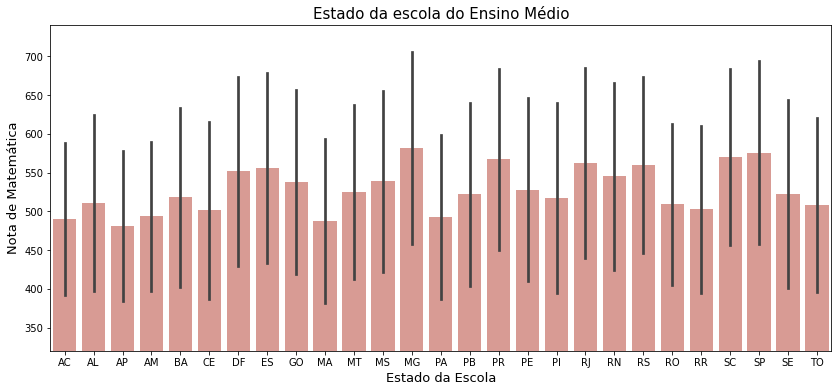

In [ ]:
# Análise da relação Nota de Matemática x Estado da escola onde concluiu o Ensino Médio 
var13_1 = 'CO_UF_ESC'
A = 'AC'
B = 'AL'
C = 'AP'
D = 'AM'
E = 'BA'
F = 'CE'
G = 'DF'
H = 'ES'
I = 'GO'
J = 'MA'
K = 'MT'
L = 'MS'
M = 'MG'
N = 'PA'
O = 'PB'
P = 'PR'
Q = 'PE'
R = 'PI'
S = 'RJ'
T = 'RN'
U = 'RS'
V = 'RO'
W = 'RR'
X = 'SC'
Y = 'SP'
Z = 'SE'
AA = 'TO'

plotdata = pd.concat([csv_enem[notamt], csv_enem[var13_1].map({12: A, 27: B, 16: C, 13:D, 29: E, 23: F, 53: G, 32: H, 52: I, 21: J, 51: K, 50: L, 31: M, 15: N, 25: O, 41: P, 26: Q, 22: R, 33: S, 24: T, 43: U, 11: V, 14: W, 42: X, 35: Y, 28: Z, 17: AA})], axis=1)
f, ax = plt.subplots(figsize=(14, 6))
fig = sns.barplot(x=var13_1, y=csv_enem[notamt], data=plotdata, order=[A, B, C, D, E ,F ,G , H, I,J, K, L, M, N, O, P, Q, R, S, T, U, V, W, X, Y, Z, AA], ci='sd', color='salmon', saturation=.5)
fig.axis(ymin=320);
ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
fig.set_title("Estado da escola do Ensino Médio", fontsize=15)
fig.set_xlabel("Estado da Escola", fontsize=13)
fig.set_ylabel("Nota de Matemática", fontsize=13)

**2 - Tratamento de dados**
--

A partir de agora vamos analisar a adequabilidade do banco de dados para nossa análise e fazer correções onde se fizer necessário.

**2.1 - Missing Data**

A partir daqui verificaremos quais atributos estão sem dados e como cada situação será tratada.

In [ ]:
cols_candidatos = ['NU_INSCRICAO', 'NU_NOTA_MT', 'Q001', 'Q002', 'Q003', 'Q004','Q005', 'Q006', 'Q007', 'Q010', 'Q024', 'TP_SEXO', 'TP_COR_RACA', 'TP_ESCOLA', 'TP_DEPENDENCIA_ADM_ESC', 'CO_UF_ESC']

#missing data
model_data = csv_enem[cols_candidatos]

total = model_data.isnull().sum().sort_values(ascending=False)
print('missing data:\n', total)

missing data:
 TP_DEPENDENCIA_ADM_ESC    2001973
CO_UF_ESC                 2001973
Q001                        26490
Q002                        26490
Q003                        26490
Q004                        26490
Q005                        26490
Q006                        26490
Q007                        26490
Q010                        26490
Q024                        26490
NU_INSCRICAO                    0
NU_NOTA_MT                      0
TP_SEXO                         0
TP_COR_RACA                     0
TP_ESCOLA                       0
dtype: int64


A variável que trata em qual Unidade da Federação pertence a escola na qual o aluno cursou o Ensino Médio apresenta problema grave de missing values e será excluída, será então considerada a variável que diz sobre a residência do estudante, dessa forma, acredito que podemos manter a análise geográfica do rendimento sem o prejuízo de usar outros métodos para completar os dados.

In [ ]:
situationstudent = csv_enem['TP_ST_CONCLUSAO'].value_counts() 
print(situationstudent)
print('Nós temos', csv_enem['TP_ST_CONCLUSAO'].isnull().values.sum(), 'missing values no atributo que define a residência do aluno.')

1    1391768
2     793506
3     335658
4       6462
Name: TP_ST_CONCLUSAO, dtype: int64
Nós temos 0 missing values no atributo que define a residência do aluno.


Agora iremos reduzir nas questões de 1 a 4 os Missing Values em decorrência da resposta "Não sei". Iremos considerar o maior grau de escolaridade entre pai e mãe e o maior nível de emprego entre estes. Essa medida atende a candidatos que são órfãos de pai e/ou mãe e que naturalmente responderiam "Não sei" a este questionamento. É pouco razoável supor que respostas "Não sei" para pai e mãe, para quem tenha pelo um dos dois, se deva ao fato do candidato não saber a profissão dos pais.  

In [ ]:
total = len(model_data.index)

#str(round(percent,1)) +'%'

r1 = model_data[(model_data['Q002'] == 'H') & (model_data['Q001'] == 'H')]['Q002'].count()
r1_percent = ' ('+str(round(r1*100/total,1))+'%)'
print('respondentes que não sabem a escolaridade da mãe nem do pai: '+ str(r1)+r1_percent)

r0 = model_data[(model_data['Q002'] == 'H') | (model_data['Q001'] == 'H')]['Q002'].count() - 2*r1
r0_percent = ' ('+str(round(r0*100/total,1))+'%)'
print('respondentes que não sabem a escolaridade da mãe mas sabem do pai, ou vice versa: '+str(r0)+r0_percent)

r2 = model_data[(model_data['Q004'] == 'F') & (model_data['Q003'] == 'F')]['Q002'].count()
r2_percent = ' ('+str(round(r2*100/total,1))+'%)'
print('\nrespondentes que não sabem a ocupação da mãe nem do pai: '+ str(r2)+r2_percent)

#r3 = model_data[((model_data['Q002'] == 'H') & (data['Q001'] == 'H') & (model_data['Q004'] == 'F') & (data['Q003'] == 'F'))]['Q002'].count()
#print('\nunião entre os grupos acima: ', r1+r2-r3)

r4 = model_data[(model_data['TP_COR_RACA'] == 0)]['Q002'].count()
r4_percent = ' ('+str(round(r4*100/total,1))+'%)'
print('\nrespondentes que não declararam raça: '+ str(r4)+r4_percent)

respondentes que não sabem a escolaridade da mãe nem do pai: 35675 (1.4%)
respondentes que não sabem a escolaridade da mãe mas sabem do pai, ou vice versa: 139519 (5.5%)

respondentes que não sabem a ocupação da mãe nem do pai: 67945 (2.7%)

respondentes que não declararam raça: 47888 (1.9%)


Agora iremos eliminar os candidatos que não sabem a escolaridade do pai e da mãe, o que representa 1,8% do nosso banco.
Iremos ainda excluir os dados de profissão do pai e da mãe, por acreditarmos ser um fator diretamente relacionado a renda.

In [ ]:
#Eliminando candidatos que nao sabem a escolaridade do pai nem da mae

model_data2 = model_data[(model_data['Q002'] != 'H') | (model_data['Q001'] != 'H')]
print('Meu banco de dados agora tem', len(cols), 'colunas e', len(model_data2.index), 'linhas.' )

# Agora eliminamos as colunas da ocupação profissional dos pais e do tipo de escola.

cols = ['NU_INSCRICAO', 'NU_NOTA_MT', 'Q001', 'Q002','Q005', 'Q006', 'Q007', 'Q010', 'Q024', 'TP_SEXO', 'TP_COR_RACA', 'TP_ESCOLA', 'TP_DEPENDENCIA_ADM_ESC', 'CO_UF_ESC']

model_data3 = model_data2[cols]

Meu banco de dados agora tem 15 colunas e 2491719 linhas.


Agora vamos fazer a coluna que tem a maior escolaridade de pai e mãe.

In [ ]:
model_data3_labels = model_data3.copy()

#feature eng 1: max_escol
#primeiro vamos mapear os níveis de escolaridade A, ..., G, H em números. Como H = "não sei", colocaremos como -1
model_data3_labels['Q001'] = model_data3_labels['Q001'].map({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H':-1})
model_data3_labels['Q002'] = model_data3_labels['Q002'].map({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H':-1})
#agora vamos criar uma coluna que é a maior escolaridade entre pai e mae
model_data3_labels['max_escol'] = model_data3_labels[['Q001', 'Q002']].max(axis=1)
#e jogar fora as duas colunas originais de escolaridade do pai e da mãe
model_data3_labels.drop(['Q001', 'Q002', 'TP_ESCOLA', 'TP_DEPENDENCIA_ADM_ESC', 'CO_UF_ESC'], axis=1, inplace=True)

model_data3_labels['TP_SEXO'] = model_data3_labels['TP_SEXO'].map({'M': 0, 'F': 1})

model_data3_labels['Q006'] = model_data3_labels['Q006'].map({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H':7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16})

model_data3_labels['Q007'] = model_data3_labels['Q007'].map({'A': 0, 'B': 1, 'C': 2, 'D': 3})

model_data3_labels['Q010'] = model_data3_labels['Q010'].map({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4})

model_data3_labels['Q024'] = model_data3_labels['Q024'].map({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4})


model_data3_labels.head()

,NU_INSCRICAO,NU_NOTA_MT,Q005,Q006,Q007,Q010,Q024,TP_SEXO,TP_COR_RACA,max_escol
1,200001195856,711.3,NaN,NaN,NaN,NaN,NaN,0,3,NaN
3,200001908998,759.4,NaN,NaN,NaN,NaN,NaN,0,3,NaN
5,200003132410,526.7,5.0,2.0,0.0,0.0,1.0,1,3,2.0
7,200001334237,753.2,NaN,NaN,NaN,NaN,NaN,0,1,NaN
8,200006762554,448.5,2.0,1.0,0.0,0.0,0.0,1,3,2.0


Criando o conjunto de teste

In [ ]:
y = model_data2['NU_NOTA_MT']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(model_data3_labels, y, test_size=0.2, random_state=42)
float('3,14159'.replace(',', '.'))

3.14159

FAzendo a regressão 

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(model_data3_labels, y)
float64('NaN'.replace('NaN', '0'))

ValueError: ignored

In [ ]:
some_data = model_data3_labels.iloc[:5]
some_labels = model_data3_labels.iloc[1:5]
print('Predictions:', lin_reg.predict(some_data))
print('Labels:', list(some_labels))

ValueError: ignored

In [ ]:
from sklearn.metrics import mean_squared_error
math_predictions = lin_reg.predict(model_data3_labels)
lin_mse = mean_squared_error(y, math_predictions)
lin_rmse = np.sqrt(lin_mse)
print(lin_rmse)


ValueError: ignored

Fazendo a árvore de decisão

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(model_data3_labels, y)

DecisionTreeRegressor()

In [ ]:
math_predictions = tree_reg.predict(model_data3_labels)
tree_mse = mean_squared_error(y, math_predictions)
tree_rmse = np.sqrt(tree_mse)
print(tree_rmse)

6.252695558013425e-12


Validação cruzada

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, model_data3_labels, y,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [ ]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [ ]:
display_scores(tree_rmse_scores)

Scores: [0.00125945 0.00114147 0.0013776  0.00107765 0.00102374 0.00124815
 0.00194823 0.00198424 0.00103748 0.00134641]
Mean: 0.0013444419276070492
Standard deviation: 0.00033180531968200804


Agora vamos rodar a Floresta Aleatória

In [ ]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(model_data3_labels, y)

RandomForestRegressor()

In [ ]:
math_predictions = forest_reg.predict(model_data3_labels)
forest_mse = mean_squared_error(y, math_predictions)
forest_rmse = np.sqrt(forest_mse)
print(tree_rmse)

6.252695558013425e-12


In [ ]:
scores = cross_val_score(forest_reg, model_data3_labels, y,
                         scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-scores)

NameError: ignored

In [ ]:
display_scores(forest_rmse_scores)

Fazendo o Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = [
              {'n_estimators': [3, 10, 30], 'max_features':[2, 4, 6, 8]},
              {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(model_data3_labels, y)


NameError: ignored

In [ ]:
grid_search.best_params_

NameError: ignored

In [ ]:
y = model_data3_labels['NU_NOTA_MT']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X3_labels, y, test_size=0.3, random_state=101)

NameError: ignored

In [ ]:
from xgboost import XGBRegressor

xgbr = XGBRegressor(n_estimators=1000)
xgbr_model = xgbr.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_test, y_test)], verbose=0)
            

#plotando as feature importances
from xgboost import plot_importance

plot_importance(xgbr, show_values=False, importance_type="weight")
plt.title("Feature Importances by weight")
plt.show()

plot_importance(xgbr, show_values=False, importance_type="cover")
plt.title("Feature Importances by cover")
plt.show()


plot_importance(xgbr, show_values=False, importance_type="gain")
plt.title("Feature Importances by gain")
plt.show()

#avaliando métricas do modelo
predictions = xgbr.predict(X_test)

print('Resultado XGBoost')
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

sns.distplot((y_test-predictions),bins=50)

NameError: ignored

Verificamos que as features mais importantes são:

1) Máx. escolaridade dos pais

2) Renda

3) Raça

4) Se há carros na residência

5) Se há empregada doméstica